In [2]:
!pip install pyspark
!pip install seaborn matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.2-py2.py3-none-any.whl size=317812365 sha256=fa63c2f48b8e1f6eff543285f3746d4a845e9623f7349502cbaaadfe4fb84b0f
  Stored in directory: /root/.cache/pip/wheels/34/34/bd/03944534c44b677cd5859f248090daa9fb27b3c8f8e5f49574
Successfully built pyspark


Mean Squared Error (MSE): 0.007204820474657998
R-squared (R2): 0.9999878577178806


<Figure size 1200x600 with 0 Axes>

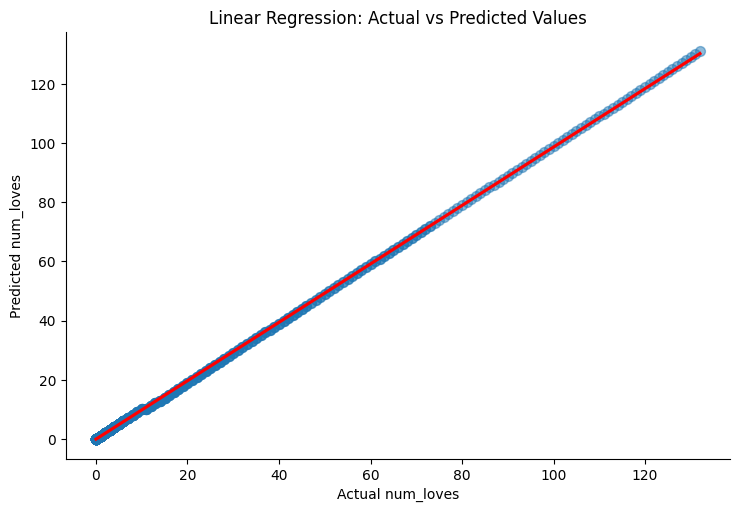

In [13]:
# Linear Regession
spark = SparkSession.builder \
    .appName("LinearRegressionPipelineExample") \
    .getOrCreate()

# Step 2: Load data file into DataFrame
# Replace 'path/to/FBLiveTH.csv' with your actual file path
data = spark.read.csv('/content/fb_live_thailand.csv', header=True, inferSchema=True)

# Step 3: Use StringIndexer to prepare data
indexer_reactions = StringIndexer(inputCol="num_reactions", outputCol="num_reactions_ind")
indexer_loves = StringIndexer(inputCol="num_loves", outputCol="num_loves_ind")

# Step 4: Use VectorAssembler to create feature vector
assembler = VectorAssembler(
    inputCols=["num_reactions_ind", "num_loves_ind"],
    outputCol="features"
)

# Step 5: Define Linear Regression model
lr = LinearRegression(
    featuresCol="features",
    labelCol="num_loves_ind",
    maxIter=10,
    regParam=0.1,
    elasticNetParam=0.8
)

# Step 6: Create a Pipeline with the stages
# Removed indexer_reactions and indexer_loves from the pipeline
pipeline = Pipeline(stages=[assembler, lr])

# Step 7: Split data into train and test datasets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=1234)

# Step 8: Fit the pipeline model on the training data
# Apply the StringIndexers before fitting the pipeline
train_data = indexer_reactions.fit(train_data).transform(train_data)
train_data = indexer_loves.fit(train_data).transform(train_data)
pipeline_model = pipeline.fit(train_data)

# Step 9: Transform the test data using the pipeline model
# Apply the StringIndexers to the test data before transforming
test_data = indexer_reactions.fit(test_data).transform(test_data)
test_data = indexer_loves.fit(test_data).transform(test_data)
predictions = pipeline_model.transform(test_data)

# Step 10: Create RegressionEvaluator
evaluator = RegressionEvaluator(
    labelCol="num_loves_ind",
    predictionCol="prediction"
)

# Evaluate Mean Squared Error (MSE)
evaluator.setMetricName("mse")
mse = evaluator.evaluate(predictions)
print(f"Mean Squared Error (MSE): {mse}")

# Evaluate R-squared (R2)
evaluator.setMetricName("r2")
r2 = evaluator.evaluate(predictions)
print(f"R-squared (R2): {r2}")

# Step 11: Select and convert columns, order by 'prediction' in descending order
selected_data = predictions.select(
    col("num_loves_ind").cast(IntegerType()).alias("num_loves"),
    col("prediction").cast(IntegerType()).alias("prediction")
).orderBy(col("prediction").desc())

# Convert to Pandas DataFrame
selected_data_pd = selected_data.toPandas()

# Step 12: Plotting using Seaborn's lmplot
plt.figure(figsize=(12, 6))
sns.lmplot(
    data=selected_data_pd,
    x='num_loves',
    y='prediction',
    aspect=1.5,  # Aspect ratio of the plot
    scatter_kws={'s': 50, 'alpha': 0.5},  # Scatter plot customizations
    line_kws={'color': 'red'}  # Line plot customizations
)

plt.title('Linear Regression: Actual vs Predicted Values')
plt.xlabel('Actual num_loves')
plt.ylabel('Predicted num_loves')
plt.show()

# Stop SparkSession
spark.stop()

#DECISION

+-------------+----------+
|num_loves_ind|prediction|
+-------------+----------+
|          2.0|       2.0|
|          0.0|       0.0|
|          0.0|       0.0|
|          0.0|       0.0|
|          0.0|       0.0|
+-------------+----------+
only showing top 5 rows

R2 Score: 0.46272473874794495


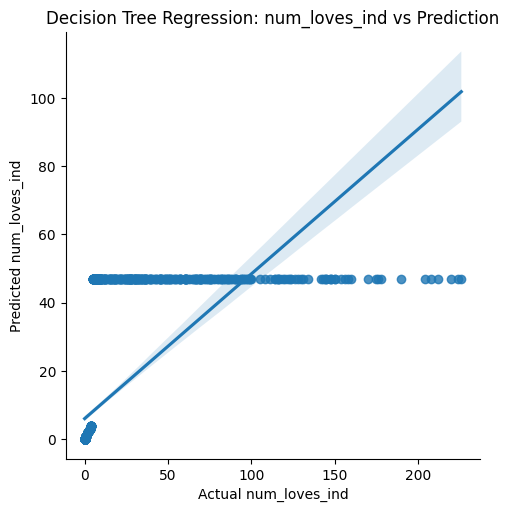

In [7]:
# Step 1: Install PySpark and other required libraries (if running in Colab)

# Step 2: Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.sql.types import IntegerType
import seaborn as sns
import matplotlib.pyplot as plt

# Step 3: Create a SparkSession
spark = SparkSession.builder.appName("DecisionTreeRegressionFBLive").getOrCreate()

# Step 4: Load data into DataFrame (fb_live_thailand.csv)
data = spark.read.csv("fb_live_thailand.csv", header=True, inferSchema=True)

# Step 5: Use StringIndexer to prepare data (num_reactions and num_loves)
indexer_reactions = StringIndexer(inputCol="num_reactions", outputCol="num_reactions_ind")
indexer_loves = StringIndexer(inputCol="num_loves", outputCol="num_loves_ind")

# Step 6: Fit and transform the data with the StringIndexer
indexed_data = indexer_reactions.fit(data).transform(data)
indexed_data = indexer_loves.fit(indexed_data).transform(indexed_data)

# Step 7: OneHotEncoder for the indexed columns (num_reactions_ind and num_loves_ind)
encoder_reactions = OneHotEncoder(inputCol="num_reactions_ind", outputCol="num_reactions_encoded")
encoder_loves = OneHotEncoder(inputCol="num_loves_ind", outputCol="num_loves_encoded")

# Step 8: Use VectorAssembler to create a feature vector from encoded columns
assembler = VectorAssembler(inputCols=["num_reactions_encoded", "num_loves_encoded"], outputCol="features")

# Step 9: Create Decision Tree Regressor (num_loves_ind as label)
dt = DecisionTreeRegressor(featuresCol="features", labelCol="num_loves_ind")

# Step 10: Create a pipeline that includes OneHotEncoder, VectorAssembler, and Decision Tree
pipeline = Pipeline(stages=[encoder_reactions, encoder_loves, assembler, dt])

# Step 11: Split the data into train and test datasets
train_data, test_data = indexed_data.randomSplit([0.8, 0.2], seed=1234)

# Step 12: Fit the train data into the pipeline to create the decision tree model
dt_model = pipeline.fit(train_data)

# Step 13: Use the created model to transform the test data for predictions
predictions = dt_model.transform(test_data)

# Step 14: Show 5 rows of the predictions DataFrame
predictions.select("num_loves_ind", "prediction").show(5)

# Step 15: Use RegressionEvaluator to evaluate the model
evaluator = RegressionEvaluator(labelCol="num_loves_ind", predictionCol="prediction")

# Calculate R2 Score
r2 = evaluator.setMetricName("r2").evaluate(predictions)
print(f"R2 Score: {r2}")

# Step 16: (Optional) Plotting the Actual vs Predicted values
# Convert num_loves_ind and prediction columns to Pandas for plotting
selected_data = predictions.select("num_loves_ind", "prediction").toPandas()

# Plot using seaborn
sns.lmplot(x="num_loves_ind", y="prediction", data=selected_data)
plt.title("Decision Tree Regression: num_loves_ind vs Prediction")
plt.xlabel("Actual num_loves_ind")
plt.ylabel("Predicted num_loves_ind")
plt.show()
